In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from random import randint
import pickle

# for clustering
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

# for dimension reduction
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [59]:
from utils import *

In [60]:
df_transport = pd.read_csv('transport_dataset.csv')
df_transport.shape

(416314, 2)

In [61]:
df_transport.head()

path  car_id
0  raw_data/veriwild/veriwild/1/00001/000001.jpg       1
1  raw_data/veriwild/veriwild/1/00001/000002.jpg       1
2  raw_data/veriwild/veriwild/1/00001/000003.jpg       1
3  raw_data/veriwild/veriwild/1/00001/000004.jpg       1
4  raw_data/veriwild/veriwild/1/00001/000005.jpg       1

In [62]:
# with open('descriptors/efficientnet-b7.pickle', 'rb') as f:
    # enb7 = pickle.load(f)
with open('descriptors/vdc_color.pickle', 'rb') as f:
    vdcc = pickle.load(f)
# with open('descriptors/vdc_type.pickle', 'rb') as f:
#     vdct = pickle.load(f)

In [63]:
n_samples = 499

# data = np.hstack([enb7, vdcc, vdct])
data = vdcc.copy()
idx = np.random.choice(data.shape[0], n_samples, replace=False)

idx

array([ 49789, 154581, 164768, ..., 158524, 298173, 390394])

In [64]:
data = data[idx, :]

df = df_transport.iloc[idx, :]

data.shape, df.shape

((4000, 128), (4000, 2))

In [65]:
pca = PCA(0.91, random_state=42) # n_components=XXX
pca.fit(data)
data = pca.transform(data)

pca.n_components_

67

In [58]:
# ENB7 for 3000 samples
# pca = PCA(0.8, random_state=42) # EPS=7 max clusters found
# pca = PCA(0.98, random_state=42) # EPS=9 max cluster found

In [1]:
# # for i in range(x.shape[0]):
# for i in range(1):
#     # plt.plot(np.sort(x[i]))
#     plt.plot(x[i])

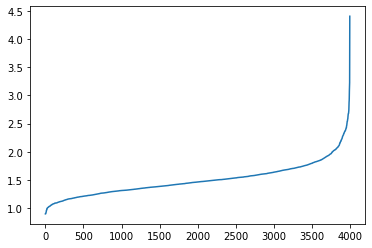

In [66]:
from sklearn.neighbors import NearestNeighbors

neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(data)
distances, indices = nbrs.kneighbors(data)

distances = np.sort(distances, axis=0)
distances = distances[:,1]

plt.plot(distances)

In [68]:
def calc_clusters_size_std(labels):
    unique, counts = np.unique(labels, return_counts=True)
    return counts.std()

In [69]:
from sklearn.metrics import calinski_harabasz_score

for eps in np.arange(0.01, 2.5, step=0.15):
    for min_samples in np.arange(2, 5, step=1):
        # eps = 1.5
        dbscan = DBSCAN(
            eps=eps,
            min_samples=min_samples,
            metric='euclidean',
            #  algorithm ='auto'
        )
        dbscan.fit(data)
        c = np.unique(dbscan.labels_).shape[0]
        score = 0
        if c == 1:
            continue
        
        score = calinski_harabasz_score(data, dbscan.labels_)
        std = calc_clusters_size_std(dbscan.labels_)
        print(f'eps={eps} min_samples={min_samples} clusters={c} calinski_harabasz={score} std={std}')

eps=0.9099999999999999 min_samples=2 clusters=4 calinski_harabasz=1.6509235658972077 std=1728.5867059537395
eps=1.06 min_samples=2 clusters=40 calinski_harabasz=1.6608008741362592 std=610.7291134373733
eps=1.06 min_samples=3 clusters=5 calinski_harabasz=2.8408443812022273 std=1592.0001256281357
eps=1.06 min_samples=4 clusters=3 calinski_harabasz=3.2509532645784467 std=1879.2541664772816
eps=1.21 min_samples=2 clusters=117 calinski_harabasz=3.188529220478565 std=322.6030593065004
eps=1.21 min_samples=3 clusters=35 calinski_harabasz=6.844936104704304 std=610.2143684888157
eps=1.21 min_samples=4 clusters=22 calinski_harabasz=8.689371684306098 std=779.5406943930996
eps=1.3599999999999999 min_samples=2 clusters=123 calinski_harabasz=3.637713426396701 std=255.71361488766806
eps=1.3599999999999999 min_samples=3 clusters=40 calinski_harabasz=6.860689530403474 std=466.14450549159113
eps=1.3599999999999999 min_samples=4 clusters=18 calinski_harabasz=11.234305592068548 std=703.1892866359002
eps=1

In [83]:
dbscan = DBSCAN(
    min_samples=3,
    eps=2,
)
dbscan.fit(data)
np.unique(dbscan.labels_)

array([-1,  0,  1], dtype=int64)

In [84]:
df.loc[:, 'label'] = dbscan.labels_

In [85]:
for n_clusters in np.arange(2,  25, step=1):
    model = KMeans(n_clusters=n_clusters, random_state=42)
    model.fit(data)
    score = calinski_harabasz_score(data, model.labels_)
    std = calc_clusters_size_std(model.labels_)
    print(f'n={n_clusters} calinski_harabasz={score} std={std} i={model.inertia_}')

n=2 calinski_harabasz=2256.8518387625627 std=4.0 i=20252.623046875
n=3 calinski_harabasz=1626.2069733217745 std=775.8265842885825 i=17469.7421875
n=4 calinski_harabasz=1335.5882405453838 std=500.0204995797672 i=15821.2333984375
n=5 calinski_harabasz=1110.2551384279323 std=310.66831186974963 i=15004.9375
n=6 calinski_harabasz=964.1620887376783 std=207.88992814040373 i=14356.5791015625
n=7 calinski_harabasz=852.9460447499998 std=225.88420367389074 i=13886.8896484375
n=8 calinski_harabasz=767.2469872504478 std=200.30414374146133 i=13509.6298828125
n=9 calinski_harabasz=703.0226429081199 std=160.79186761574113 i=13151.63671875
n=10 calinski_harabasz=656.1714149826357 std=195.5714703120064 i=12775.8232421875
n=11 calinski_harabasz=607.8385026387106 std=172.05140496495002 i=12554.6015625
n=12 calinski_harabasz=576.5454470531852 std=184.0956876795929 i=12232.38671875
n=13 calinski_harabasz=544.749118073429 std=152.12210915798715 i=12003.8994140625
n=14 calinski_harabasz=513.1791741217097 std=

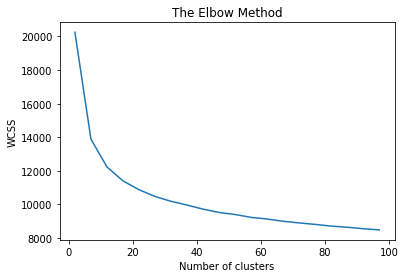

In [86]:
# Using the elbow method to find  the optimal number of clusters
# from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

wcss = []
for i in range(2, 100, 5):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(data)
    wcss.append(kmeans.inertia_)
    # wcss.append(sum(np.min(cdist(data, kmeans.cluster_centers_, 'euclidean'), axis=1)) / data.shape[0])
plt.plot(range(2, 100, 5), wcss)
# plt.plot(K, inertias, 'bx-')
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [87]:
kmeans = KMeans(n_clusters=25, init='k-means++', max_iter=300, n_init=10, random_state=42)
kmeans.fit(data)

KMeans(n_clusters=25, random_state=42)

In [88]:
df.loc[:, 'label'] = kmeans.labels_

In [89]:
tsne = TSNE(n_components=2, random_state=42)
projection = tsne.fit_transform(data)

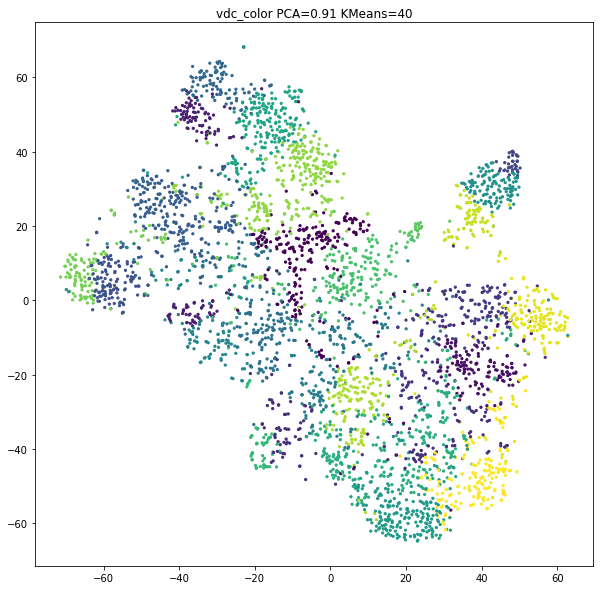

In [90]:
plt.figure(figsize=(10,10))
plt.title(f'vdc_color PCA={0.91} KMeans={40}')
plt.scatter(x=projection[:,0], y=projection[:,1], c=kmeans.labels_, s=5)

In [91]:
# from keras.preprocessing.image import load_img 
# from keras.preprocessing.image import img_to_array 
from skimage import io

def show_clusters(df, max_images=10, size=25, title=None):
    i = 0
    clusters = df.groupby('label')
    rows = len(clusters.groups.keys())
    figsize = (int(size * (max_images/rows) * 1), size)
    plt.figure(figsize=figsize)
    if title:
        plt.suptitle(title, size=16)
        # plt.title(title)
    for c in clusters.groups.keys():
        cdf = clusters.get_group(c)
        if cdf.shape[0] > max_images:
            cdf = cdf.sample(max_images)
        for index, row in cdf.iterrows():
            plt.subplot(rows, max_images, i+1)
            file = row['path']
            img = io.imread(file)
            img = np.array(img)
            plt.imshow(img)
            plt.axis('off')
            i += 1

In [128]:
clusters = df.groupby(['label']).size().to_frame(name='count').reset_index()
clusters.sort_values('count', ascending=False)
clusters.head()

label  count
0      0    225
1      1    158
2      2    141
3      3    150
4      4    183

In [129]:
clusters.plot.bar(x='label', y='count', rot=0)

TypeError: Cannot interpret '<attribute 'dtype' of 'numpy.generic' objects>' as a data type

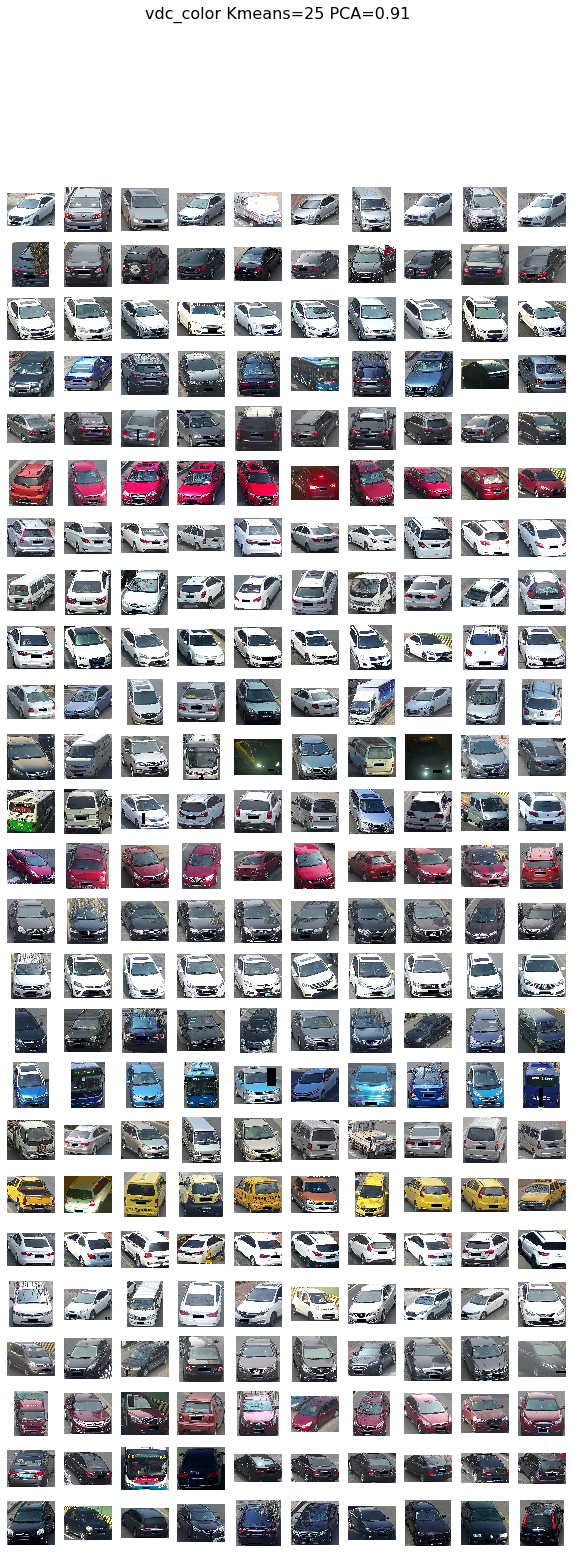

In [94]:
# df_cluster = df[df['label'] == 3]
show_clusters(df, max_images=10, size=25, title=f'vdc_color Kmeans=25 PCA=0.91')
# df_cluster.shape